In [71]:
# Telling matplotlib to work in the program and not as an external window
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from numpy import *
import matplotlib.cm as cm
import time
from scipy.optimize import curve_fit
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import seaborn as sns; import pandas as pd
import warnings
from scipy.optimize import OptimizeWarning
plt.rcParams.update({'font.size': 14})
import matplotlib.gridspec as gridspec

In [72]:
folder = '.'
length = 60
data = np.loadtxt(r''+str(folder)+'/DataAll/DataSim-file'+str(0)+'.txt')
lengthdata2 = len(data)
files2 = np.linspace(0,length,length+1)
lengthfiles2 = len(files2)
datasim = np.zeros((lengthdata2,lengthfiles2))
for i in range(lengthfiles2):
    number = int(files2[i])
    data = np.loadtxt(r''+str(folder)+'/DataAll/DataSim-file'+str(number)+'.txt')
    datasim[:,i] = data
#0 - vright, 1 - vrightx, 2 - corrangleright, 3 - HWHMrightangle, 4 - varrightx, 5 - varrighty
#6 - HWHMlaserangle, 7 - varlaserx, 8 - varlasery, 9 - meanlaserx, 10 - expect meanlaserx, 11 - original v input

In [73]:
dt = 0.03
videosize = 1000
binning = 2
frametransfer = False
flashlight = True
flashtime = 0.01
programtime = 12.8103745397
radius = 2.19/2 * 1e-6
D_0 = 7.4e-14
pxtomum = 0.027e-6#0.0719e-6                    #px to µm vonversion
delaytime = (1032/27e6+1.9176e-6)*videosize/binning+programtime*1e-3+1e-3*2
if flashlight == True: delaytime += dt - flashtime/2
else: delaytime += dt/2
if frametransfer == True: delaytime += videosize/binning*1.9176e-6
print('Theory - inserting: delay =',round(delaytime,2),'s - dt =',round(dt,2),'s - r =',round(radius*1e6,2),'µm - D =',round(D_0*1e12,2),'µm^2/s')

variance = 3 * 2*D_0*delaytime/radius**2
HWHM = np.sqrt(2*np.log(2))*np.sqrt(variance)*180/np.pi
sigma = 1/2 * (1-np.exp(-2*variance))

theorydata = np.zeros((10,lengthfiles2))
for i in range(lengthfiles2):
    vthermo = datasim[0,i]
    HWHMsim = datasim[3,i]
    stdsim = HWHMsim/np.sqrt(2*np.log(2))
    varsim = (stdsim*np.pi/180)**2
    sigmasim = 1/2 * (1-np.exp(-2*varsim))
        
    theorydata[0,i] = variance                                          #3 * variance
    theorydata[1,i] = HWHM                                              #HWHM
    theorydata[2,i] = vthermo*np.exp(-variance/2)*dt                    #mean x
    theorydata[3,i] = (1-sigma)*vthermo**2*dt**2 - np.exp(-variance)*vthermo**2*dt**2 + 2*D_0*dt  #varx
    theorydata[4,i] = sigma*vthermo**2*dt**2 + 2*D_0*dt                 #vary
    theorydata[5,i] = vthermo
    
    theorydata[6,i] = vthermo*np.exp(-varsim/2)*dt                      #mean x
    theorydata[7,i] = (1-sigmasim)*vthermo**2*dt**2 - np.exp(-varsim)*vthermo**2*dt**2 + 2*D_0*dt  #varx
    theorydata[8,i] = sigmasim*vthermo**2*dt**2 + 2*D_0*dt              #vary
    theorydata[9,i] = np.sqrt(2*np.log(2))*np.sqrt(varsim)*180/np.pi    #HWHM

Theory - inserting: delay = 0.06 s - dt = 0.03 s - r = 1.09 µm - D = 0.07 µm^2/s


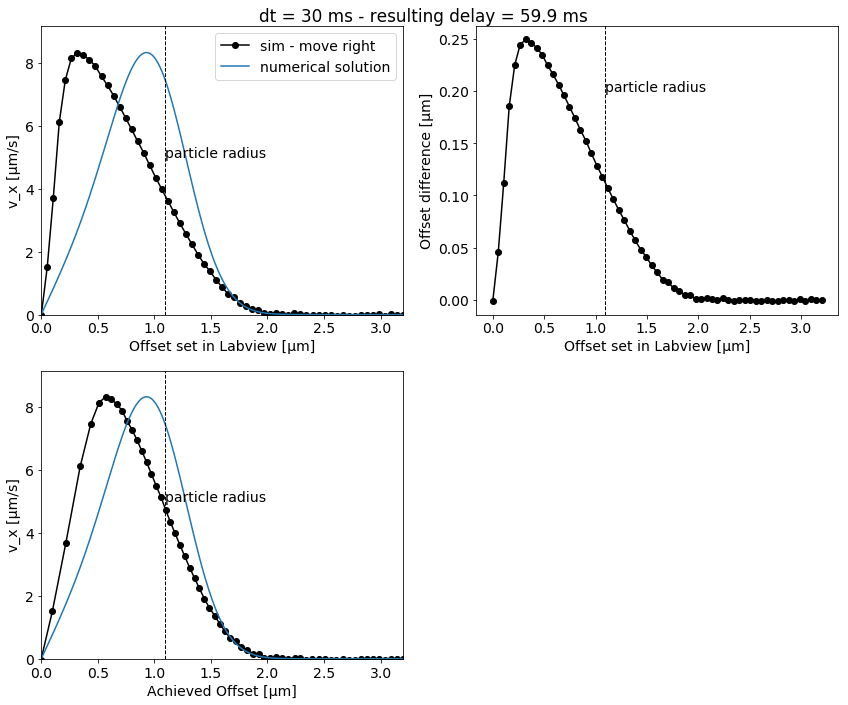

In [74]:
x3 = -datasim[-2,:]
vel = np.loadtxt('DataVvsOffset.txt')
velparticle = np.zeros((len(vel),3))                #Load the velocity of the particle of depending on the distance to the laser
velparticle[:,0] = vel[:,0]*1e-6
velparticle[:,2] = -vel[:,1]
maxvelocity = max(datasim[1,:])*10**-6#5.25e-6        #velocity of the particle depending on the laser power [m/s]
velparticle[:,1] = velparticle[:,2]*maxvelocity/max(velparticle[:,2])

fig=plt.figure(1, figsize = (12,10) )
plt.suptitle('dt = '+str(30)+' ms - resulting delay = '+str(round(delaytime*1e3,1))+' ms')
plt.subplot(2,2,1)
#plt.title('Measurement vs particle position')
plt.xlabel('Offset set in Labview [µm]')
#plt.xlabel('Original max velocity input [µm/s]')
plt.ylabel('v_x [µm/s]')
plt.plot(x3,datasim[1,:],'-o',c='k',label='sim - move right')
plt.plot(velparticle[:,0]*1e6,velparticle[:,1]*1e6,label='numerical solution')
plt.axvline(x=radius*1e6,linewidth=1, color = 'k',linestyle='--')
plt.text(radius*1e6,5,'particle radius')
plt.xlim([0,max(x3)])
plt.ylim([0,1.1*max(datasim[1,:])])
plt.title(' ')
plt.legend()

plt.subplot(2,2,2)
plt.plot(x3,datasim[10,:]-datasim[9,:],'-o',c='k',label='sim - move right')
plt.axvline(x=radius*1e6,linewidth=1, color = 'k',linestyle='--')
plt.text(radius*1e6,0.2,'particle radius')
plt.xlabel('Offset set in Labview [µm]')
plt.ylabel('Offset difference [µm]')
#plt.title('Difference between desired and achieved offset')

plt.subplot(2,2,3)
plt.plot(-datasim[9,:],datasim[1,:],'-o',c='k',label='sim - move right')
plt.plot(velparticle[:,0]*1e6,velparticle[:,1]*1e6,label='numerical solution')
plt.axvline(x=radius*1e6,linewidth=1, color = 'k',linestyle='--')
plt.text(radius*1e6,5,'particle radius')
plt.xlim([0,max(x3)])
plt.ylim([0,1.1*max(datasim[1,:])])
plt.xlabel('Achieved Offset [µm]')
plt.ylabel('Offset difference [µm]')
plt.ylabel('v_x [µm/s]')
plt.tight_layout() 
plt.savefig('Simulation.pdf', format='pdf')
plt.show()

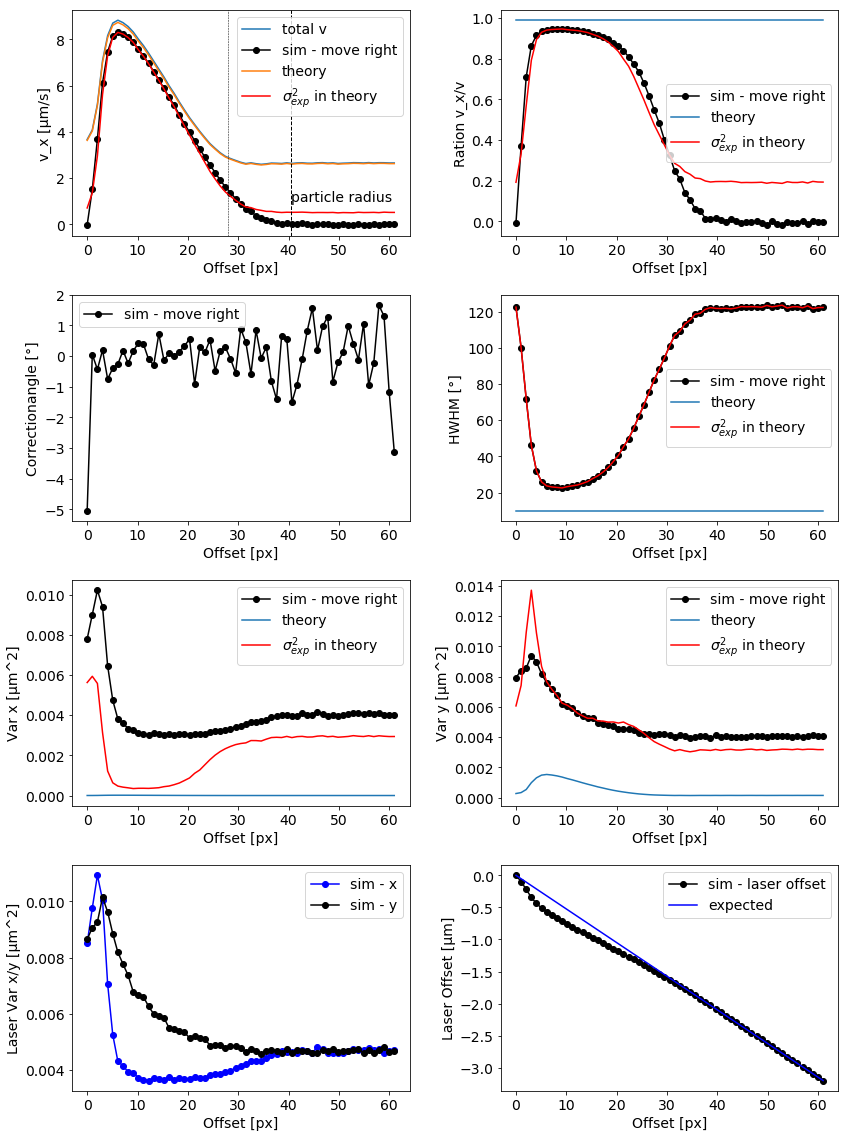

In [75]:
x3 = np.linspace(0,lengthfiles2,lengthfiles2)#datasim[1,:]
xsim = x3
xlabel = 'Offset [px]'#'v_x [µm/s]'
xwave = np.linspace(1,lengthfiles2,lengthfiles2)

fig=plt.figure(1, figsize = (12,16) )
plt.subplot(4,2,1)
#plt.title('Measurement vs particle position')
plt.xlabel(xlabel)
#plt.xlabel('Original max velocity input [µm/s]')
plt.ylabel('v_x [µm/s]')
plt.plot(x3,datasim[0,:],label='total v')
plt.plot(x3,datasim[1,:],'-o',c='k',label='sim - move right')
plt.plot(x3,theorydata[2,:]/dt,label='theory')
plt.plot(x3,theorydata[6,:]/dt,label='$\sigma_{exp}^{2}$ in theory',c='r')
plt.axvline(x=28,linewidth=0.5, color = 'k',linestyle='--')
plt.axvline(x=radius/pxtomum,linewidth=1, color = 'k',linestyle='--')
plt.text(radius/pxtomum,1,'particle radius')
plt.legend()

plt.subplot(4,2,2)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('Ration v_x/v')
plt.plot(x3,datasim[1,:]/datasim[0,:],'-o',c='k',label='sim - move right')
plt.plot(xsim,theorydata[2,:]/(theorydata[5,:]*dt),label='theory')
plt.plot(xsim,theorydata[6,:]/(theorydata[5,:]*dt),label='$\sigma_{exp}^{2}$ in theory',c='r')
plt.legend()

plt.subplot(4,2,3)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('Correctionangle [°]')
plt.plot(x3,datasim[2,:],'-o',c='k',label='sim - move right')
plt.legend()

plt.subplot(4,2,4)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('HWHM [°]')
plt.plot(x3,datasim[3,:],'-o',c='k',label='sim - move right')
plt.plot(xsim,theorydata[1,:],label='theory')
plt.plot(xsim,theorydata[9,:],label='$\sigma_{exp}^{2}$ in theory',c='r')
plt.legend()

plt.subplot(4,2,5)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('Var x [µm^2]')
plt.plot(x3,datasim[4,:],'-o',c='k',label='sim - move right')
plt.plot(xsim,theorydata[3,:],label='theory')
plt.plot(xsim,theorydata[7,:],label='$\sigma_{exp}^{2}$ in theory',c='r')
#plt.ylim([0,0.021])
plt.legend()

plt.subplot(4,2,6)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('Var y [µm^2]')
plt.plot(x3,datasim[5,:],'-o',c='k',label='sim - move right')
plt.plot(xsim,theorydata[4,:],label='theory')
plt.plot(xsim,theorydata[8,:],label='$\sigma_{exp}^{2}$ in theory',c='r')
plt.legend()

plt.subplot(4,2,7)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('Laser Var x/y [µm^2]')
plt.plot(x3,datasim[7,:],'-o',c='b',label='sim - x')
plt.plot(x3,datasim[8,:],'-o',c='k',label='sim - y')
plt.legend()

plt.subplot(4,2,8)
#plt.title('Laser vs particle position')
plt.xlabel(xlabel)
plt.ylabel('Laser Offset [µm]')
plt.plot(x3,datasim[9,:],'-o',c='k',label='sim - laser offset')
plt.plot(x3,datasim[10,:],'b',label='expected')
plt.legend()

plt.tight_layout()  
plt.savefig('Layout Simulation Left-right Sim vs Exp.pdf', format='pdf')
plt.show()